# Exploratory preprocessing

In this notebook we explore how lightkurve can simplify the data preprocessing steps conducted in `astronet` and later mimicked in `exonet`.

First we need [lightkurve](https://docs.lightkurve.org/), probably version 1.2 or above.

In [1]:
import lightkurve as lk

Now we need to understand what the preprocessing entails.  For that we can go to the [text of the original paper](http://adsabs.harvard.edu/abs/2018AJ....155...94S) in Section 3.2 titled "Light Curves":

> We then performed a few additional steps to prepare the light curves to be used as inputs to our neural network. For each TCE in the training set, we removed points corresponding to transits of any other confirmed planets in the system. Then, we "flattened" the light curve (that is, we removed low-frequency variability) by fitting a basis spline to the light curve and dividing it by the best-fit spline. To preserve transits, we removed the TCE's in-transit points while fitting the spline and linearly interpolated over those transits. We iteratively fit the spline, removed $3\sigma $ outliers, and refit the spline while interpolating over those outliers to prevent the spline from being "pulled" by discrepant points like cosmic-ray hits. This process is illustrated in Figure 3 of Vanderburg & Johnson (2014).

The next paragraph goes on to describe the method for getting the spline breakpoints.

**Section 3.3** then describes the *Input Representations*:

> We generate a **global view** of the light curve by choosing λ as a fraction of the TCE period. All light curves are binned to the same length, and each bin represents the same number of points, on average, across light curves. A disadvantage is that long-period TCEs may end up with very narrow transits that fall entirely within a small number of bins...

> We generate a **local view** of the transit by choosing λ as a fraction of the TCE duration. We consider k transit durations on either side of the event so that the transit occupies a fixed fraction of the resulting vector. This technique represents short- and long-period TCEs equally, but it only looks at part of the curve and therefore may miss important information, such as secondary eclipses 

The section concludes with a normalization procedure to make the transits all the same depth:

> ...we normalize all light curves to have median 0 and minimum value –1 so that all TCEs have a fixed transit depth.

First we'll need a mapping of target names (*e.g.* Kepler Input Catalog KIC IDs), to their respective, possibly multiple, Threshold Crossing Events.  That information is available in the DR24 products used by astronet and exonet, and soon to be updated to DR25.  For now we will [query the NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=q1_q17_dr24_tce) and save the output as an IPAC table in the `../data` directory.

In [2]:
! head -n 30 ../data/q1_q17_dr24_tce_2019.10.02_16.14.06.tbl

\ This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
\ Wed Oct  2 16:14:06 2019
\
\ COLUMN kepid:          KepID
\ COLUMN tce_plnt_num:   Planet Number
\ COLUMN tce_rogue_flag: Rogue Flag
\ COLUMN tce_delivname:  Delivery Name
\ COLUMN rowupdate:      Date of Last Update
\ COLUMN tce_datalink_dvs: Link to DV Summary
\ COLUMN tce_datalink_dvr: Link to DV Report
\ COLUMN tce_period:     Orbital Period [days]
\ COLUMN tce_period_err: Orbital Period Unc. [days]
\ COLUMN tce_time0bk:    Transit Epoch [BKJD]
\ COLUMN tce_time0bk_err: Transit Epoch Unc. [BKJD]
\ COLUMN tce_time0:      Transit Epoch [BJD]
\ COLUMN tce_time0_err:  Transit Epoch Unc. [BJD]
\ COLUMN tce_ror:        Planet-Star Radius Ratio
\ COLUMN tce_ror_err:    Planet-Star Radius Ratio Unc.
\ COLUMN tce_dor:        Planet-Star Distance over Star Radius
\ COLUMN tce_dor_err:    Planet-Star Distance over Star Radius Unc.
\ COLUMN tce_incl:       Inclination [deg]
\ COLUMN tce_incl_err:

In [3]:
from astropy.io import ascii

In [4]:
tbldr24 = ascii.read('../data/q1_q17_dr24_tce_2019.10.02_16.14.06.tbl')

The most useful columns are:
1. `kepid`
2. `tce_plnt_num`
3. `tce_period` and `tce_period_err`
4. `tce_time0bk` and `tce_time0bk_err`
5. `tce_ror` and `tce_ror_err` (is this radius?)
6. `tce_duration` and `tce_duration_err`
7. `tce_depth` and `tce_depth_err`

In [5]:
dr24_tce = tbldr24[['kepid', 'tce_plnt_num', 'tce_period', 'tce_time0bk', 'tce_duration', 'tce_depth']].to_pandas()

We'll eventually need to iterate over the other TCEs (if any) in a given target, so it's useful to have a "total number of TCEs" columns readily availble:

In [6]:
import pandas as pd

In [7]:
tce_num_per_star = dr24_tce.groupby('kepid').tce_plnt_num.apply(lambda x:len(x.unique()))
dr24_tce= pd.merge(dr24_tce, 
                   tce_num_per_star.to_frame().rename(columns={'tce_plnt_num':'tot_plnts'}),
                    how='left',on='kepid')

Let's spot check one of these TCEs:

In [8]:
dr24_tce.head(15)

,kepid,tce_plnt_num,tce_period,tce_time0bk,tce_duration,tce_depth,tot_plnts
0,1162345,2,0.831850,132.227,2.392,6.092,3
1,1292087,2,1.095240,132.133,2.122,34.530,2
2,1293031,2,0.719273,132.227,1.521,29.680,2
3,1162345,3,0.831833,131.919,2.181,27.100,3
4,1164109,1,622.408000,162.256,12.010,161.300,1
5,757450,1,8.884920,134.452,2.078,16310.000,1
6,892667,1,2.262110,132.171,7.509,29.410,1
7,892772,1,5.092600,133.451,3.399,246.500,1
8,1026032,1,8.460440,133.774,4.804,76500.000,2
9,1026032,2,4.230220,133.998,4.606,28810.000,2


### Make a function for the global and local views.

In [9]:
import numpy as np

In [10]:
kepid = 757450
tce_num = 1

In [11]:
this_kepid_mask = (dr24_tce.kepid == kepid)
this_tce_mask = (dr24_tce.tce_plnt_num == tce_num)

this_tce_df = dr24_tce[this_kepid_mask & this_tce_mask]

In [12]:
def get_folded_tce_lightcurve(kepid, tce_period, tce_time0bk, tce_duration):
    """Returns a FoldedLightCurve object for a kepler planet candidate
    
    Parameters
    ----------
    kepid : int
        The keplerid (aka KIC id) of the planet candidate as an integer
    
    tce_num : int
        The TCE number corresponding to potential multi-planet systems
        
    tce_period: float
        Period of TCE on which to fold the lightcurve
        
    tce_time0bk: float
        Time zero point, T0, in BKJD days of first observed event
        
    tce_duration: float
        Duration of the event, in *hours*
    """
    
    # Download all available quarters and 
    #  filter overlapping sources that rarely occur in the KIC
    sr = lk.search_lightcurvefile('KIC {}'.format(kepid), mission='Kepler')
    match_indices = [i for i, v in enumerate(sr.target_name) if str(kepid) in v]
    lcfs = sr[match_indices].download_all()
    
    # Stitch all the quarters together using Pre-search Data Conditioning
    lc_raw = lcfs.PDCSAP_FLUX.stitch()
    
    # Remove some outliers.
    # (hack to circumvent lightkurve binning issue)
    # Remove the top N_out outliers, where N_out is the remainder N_raw % N_bins
    n_raw, = lc_raw.time.shape
    n_bins_global = 2001
    remainder = n_raw % n_bins_global
    bin_size = n_raw // n_bins_global # Floor division
    mask = np.zeros(n_raw, dtype=bool)
    top_remainder_indices = np.argsort(lc_raw.flux)[:-1*remainder]
    mask[top_remainder_indices] = True
    
    lc_clean = lc_raw[mask]
    
    #TODO: replace with fancier splining or iterative GP modeling here.
    lc_flat = lc_clean.flatten()
    
    # Phase fold
    lc_fold = lc_flat.fold(tce_period, t0=tce_time0bk)
    
    # Bin N_raw samples into a fixed number of N_bins and renormalize to [-1, 1]
    lc_global = lc_fold.bin(bin_size, method='median').normalize() - 1
    lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1

    # Local view: keep from -4*duration : +4*duration
    fractional_duration = (tce_duration / 24.0) / tce_period

    # (hack to circumvent lightkurve binning issue)
    phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration)
    lc_zoom = lc_fold[phase_mask]
    n_raw, = lc_zoom.time.shape
    n_bins_local = 201
    remainder = n_raw % n_bins_local
    bin_size = n_raw // n_bins_local # Floor division
    mask = np.zeros(n_raw, dtype=bool)
    top_remainder_indices = np.argsort(lc_zoom.phase)[:-1*remainder]
    mask[top_remainder_indices] = True
    
    lc_local = lc_zoom[mask].bin(bin_size, method='median').normalize() -1
    
    # Normalize the local view
    lc_local = (lc_local / np.abs(lc_local.flux.min()) ) * 2.0 + 1
    
    return lc_raw, lc_local, lc_global

In [13]:
lc_raw, lc_local, lc_global = get_folded_tce_lightcurve(kepid, 
                                                        this_tce_df.tce_period.values[0], 
                                                        this_tce_df.tce_time0bk.values[0], 
                                                        this_tce_df.tce_duration.values[0])

In [14]:
lc_raw.remove_outliers()

KeplerLightCurve(ID: 757450)

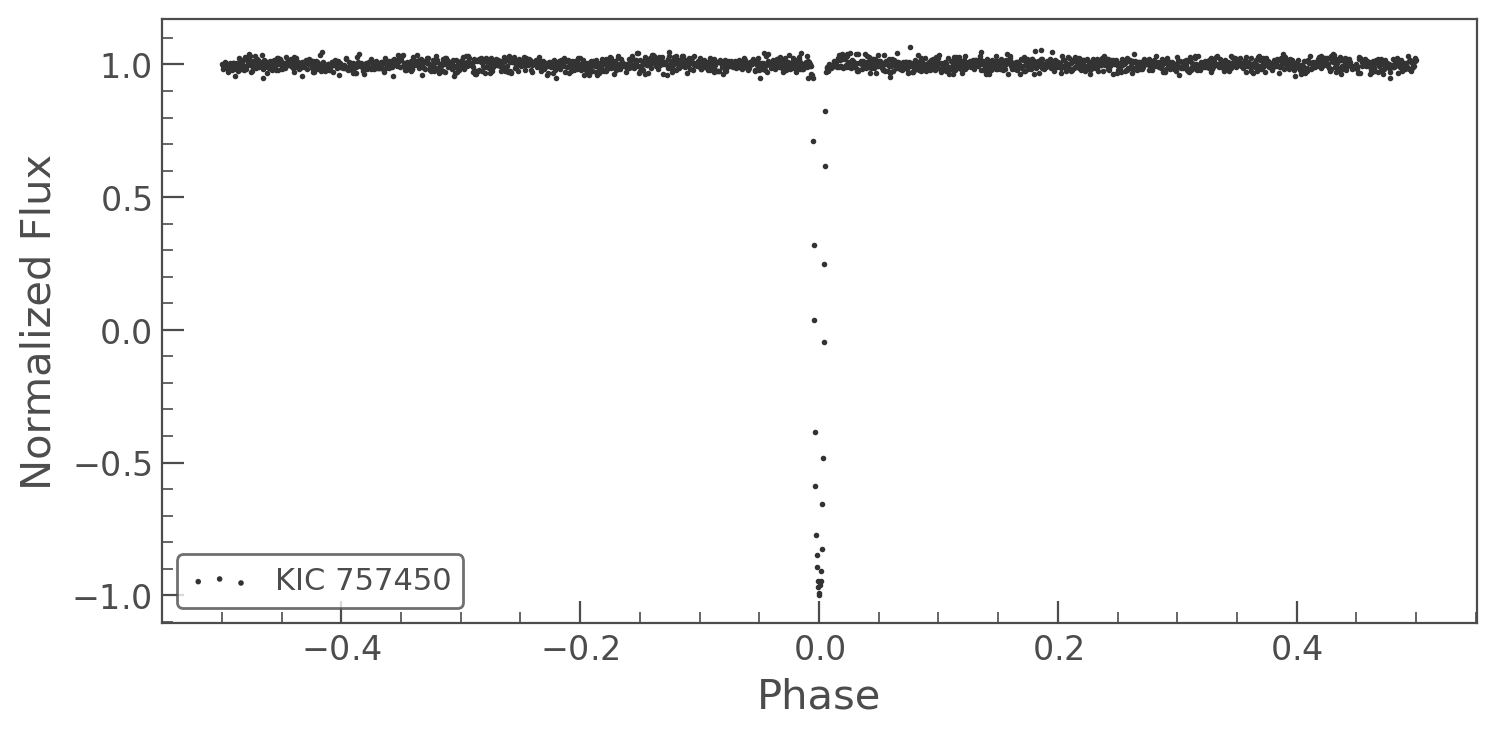

In [15]:
lc_global.scatter()

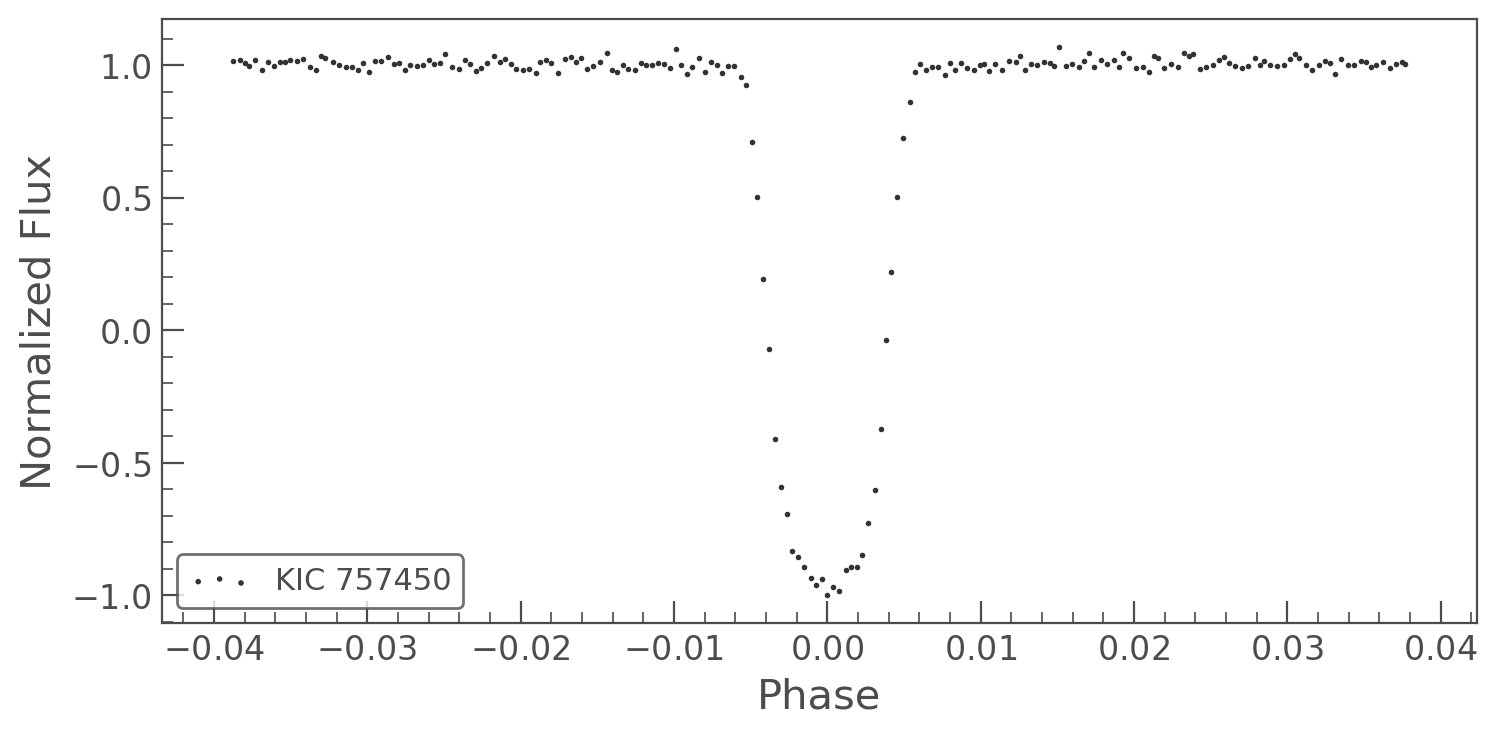

In [16]:
lc_local.scatter()

In [17]:
lc_global.flux.shape, lc_local.flux.shape

((2001,), (201,))

Yay!  We match the input representation shapes *exactly*!

## Takeaways and next steps

TODOs:

1. Mask the transits (from all TCEs in a given source)   
> Maybe change the code to accept a dataframe of the TCE list, which will simplify other aspects too.  

2. Flattening strategy
> The high dynamic range of stellar variations makes it difficult to set a single flattening parameter, akin to the need to grid search over the spline knot distance in the Shallue & Vanderburg text.  We still may want to use a GP-- in some ways it's easier, even if diminishing marginal returns.

3. Adapt lightkurve `.bin()` method to accept `bins=` parameter.